# 2. Baseline модели для Credit Card Fraud Detection

## Цель этапа
Построить и оценить базовые модели машинного обучения на сбалансированном датасете для обнаружения мошеннических транзакций.

### Ключевые задачи:
1. Подготовить данные для моделирования
2. Обучить 3-4 baseline модели
3. Сравнить их производительность по ключевым метрикам
4. Проанализировать важность признаков
5. Выбрать лучшую модель для дальнейшего улучшения

### Особенности подхода:
- Датасет искусственно сбалансирован (50/50)
- Используем обычное разбиение (не стратифицированное)
- Основные метрики: Accuracy, Precision, Recall, F1, ROC-AUC
- Анализ feature importance для интерпретации моделей

## 1. Импорт библиотек и настройки

На этом этапе импортируем все необходимые библиотеки для построения моделей, оценки и визуализации.

In [4]:
# Базовые библиотеки
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Машинное обучение
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, confusion_matrix, 
                           classification_report, roc_curve)

# Модели
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

# Настройки отображения
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Библиотеки успешно загружены")

✅ Библиотеки успешно загружены


## 2. Загрузка и подготовка данных

### Преобразования:
1. **Удаляем колонку `id`** - технический идентификатор, не содержит полезной информации для модели
2. **Логарифмируем `Amount`** - преобразуем в `Amount_log` для нормализации распределения
3. **Стандартизируем признаки** - все признаки кроме целевой переменной

### Разбиение данных:
- **80% train / 20% test**
- **Не используем стратификацию** - так как датасет уже сбалансирован
- **Фиксируем random_state=42** для воспроизводимости результатов

In [5]:
# Загрузка данных
df = pd.read_csv('../data/creditcard_2023.csv')

print("📊 Исходные данные:")
print(f"Размер: {df.shape[0]:,} строк, {df.shape[1]} колонок")
print(f"Колонки: {df.columns.tolist()}")
print(f"\nРаспределение классов:")
print(df['Class'].value_counts(normalize=True))

📊 Исходные данные:
Размер: 568,630 строк, 31 колонок
Колонки: ['id', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']

Распределение классов:
Class
0    0.5
1    0.5
Name: proportion, dtype: float64


In [6]:
# 1. Удаляем id и преобразуем Amount
print("🔧 Преобразование данных...")
df = df.drop('id', axis=1)  # Удаляем id
df['Amount_log'] = np.log1p(df['Amount'])  # Логарифмируем Amount
df = df.drop('Amount', axis=1)  # Удаляем исходный Amount

print(f"После преобразований: {df.shape[1]} колонок")
print(f"Новые колонки: {df.columns.tolist()}")

🔧 Преобразование данных...
После преобразований: 30 колонок
Новые колонки: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Class', 'Amount_log']


In [7]:
# 2. Разделение на признаки и целевую переменную
X = df.drop('Class', axis=1)
y = df['Class']

print(f"Признаки (X): {X.shape}")
print(f"Целевая переменная (y): {y.shape}")
print(f"\nРаспределение y: {y.value_counts(normalize=True).to_dict()}")

Признаки (X): (568630, 29)
Целевая переменная (y): (568630,)

Распределение y: {0: 0.5, 1: 0.5}


In [8]:
# 3. Разбиение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True  # shuffle=True по умолчанию
)

print("📈 Разбиение данных:")
print(f"Train set: {X_train.shape[0]:,} записей ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set:  {X_test.shape[0]:,} записей ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\nРаспределение классов в train: {y_train.value_counts(normalize=True).to_dict()}")
print(f"Распределение классов в test:  {y_test.value_counts(normalize=True).to_dict()}")

📈 Разбиение данных:
Train set: 454,904 записей (80.0%)
Test set:  113,726 записей (20.0%)

Распределение классов в train: {0: 0.5002484040588784, 1: 0.4997515959411216}
Распределение классов в test:  {1: 0.5009936162355134, 0: 0.4990063837644866}


In [9]:
# 4. Масштабирование признаков
print("📏 Масштабирование признаков (StandardScaler)...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Размер X_train_scaled: {X_train_scaled.shape}")
print(f"Размер X_test_scaled: {X_test_scaled.shape}")
print("✅ Данные готовы для обучения моделей")

📏 Масштабирование признаков (StandardScaler)...
Размер X_train_scaled: (454904, 29)
Размер X_test_scaled: (113726, 29)
✅ Данные готовы для обучения моделей


## 3. Baseline модели

### Выбор моделей для сравнения:
1. **Logistic Regression** - линейная модель, хороший baseline для бинарной классификации
2. **Random Forest** - ансамблевая модель, устойчива к переобучению, показывает feature importance
3. **K-Nearest Neighbors** - модель на основе близости, чувствительна к масштабированию
4. **XGBoost** - градиентный бустинг, часто показывает state-of-the-art результаты

### Стратегия обучения:
- Обучаем каждую модель с параметрами по умолчанию
- Используем кросс-валидацию для оценки устойчивости
- Сравниваем на тестовой выборке
- Анализируем важность признаков для интерпретируемости

In [10]:
# Создаем словарь для хранения моделей и результатов
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_jobs=-1),
    'K-Nearest Neighbors': KNeighborsClassifier(n_jobs=-1),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False)
}

# Словари для хранения результатов
results = {}
cv_scores = {}
predictions = {}

In [11]:
print("🚀 Обучение baseline моделей...")
print("=" * 60)

for name, model in models.items():
    print(f"\n🔹 Обучение {name}...")
    
    # Обучение модели
    model.fit(X_train_scaled, y_train)
    
    # Предсказания на тестовой выборке
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Сохраняем предсказания
    predictions[name] = {
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    # Кросс-валидация (5-fold)
    cv_accuracy = cross_val_score(model, X_train_scaled, y_train, 
                                 cv=5, scoring='accuracy', n_jobs=-1)
    cv_scores[name] = cv_accuracy
    
    # Расчет метрик
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Сохраняем результаты
    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'CV_Accuracy_Mean': cv_accuracy.mean(),
        'CV_Accuracy_Std': cv_accuracy.std()
    }
    
    print(f"   Accuracy: {accuracy:.4f}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall: {recall:.4f}")
    print(f"   F1-Score: {f1:.4f}")
    print(f"   ROC-AUC: {roc_auc:.4f}")
    print(f"   CV Accuracy: {cv_accuracy.mean():.4f} (±{cv_accuracy.std():.4f})")

print("\n✅ Все модели обучены!")

🚀 Обучение baseline моделей...

🔹 Обучение Logistic Regression...
   Accuracy: 0.9652
   Precision: 0.9771
   Recall: 0.9529
   F1-Score: 0.9648
   ROC-AUC: 0.9934
   CV Accuracy: 0.9649 (±0.0006)

🔹 Обучение Random Forest...
   Accuracy: 0.9999
   Precision: 0.9998
   Recall: 1.0000
   F1-Score: 0.9999
   ROC-AUC: 1.0000
   CV Accuracy: 0.9999 (±0.0000)

🔹 Обучение K-Nearest Neighbors...
   Accuracy: 0.9978
   Precision: 0.9956
   Recall: 1.0000
   F1-Score: 0.9978
   ROC-AUC: 0.9993
   CV Accuracy: 0.9977 (±0.0001)

🔹 Обучение XGBoost...
   Accuracy: 0.9997
   Precision: 0.9995
   Recall: 1.0000
   F1-Score: 0.9997
   ROC-AUC: 1.0000
   CV Accuracy: 0.9997 (±0.0001)

✅ Все модели обучены!


## 4. Сравнение результатов моделей

### Ключевые метрики для сравнения:
- **Accuracy** - общая точность классификации
- **Precision** - точность предсказания мошенничества (важно минимизировать false positives)
- **Recall** - полнота обнаружения мошенничества (важно минимизировать false negatives)
- **F1-Score** - гармоническое среднее Precision и Recall
- **ROC-AUC** - площадь под ROC-кривой, показывает качество разделения классов
- **CV Accuracy** - точность на кросс-валидации (оценка устойчивости)

📊 Сравнение производительности моделей:


,Accuracy,Precision,Recall,F1-Score,ROC-AUC,CV_Accuracy_Mean,CV_Accuracy_Std
Random Forest,0.9999,0.9998,1.0000,0.9999,1.0000,0.9999,0.0000
XGBoost,0.9997,0.9995,1.0000,0.9997,1.0000,0.9997,0.0001
K-Nearest Neighbors,0.9978,0.9956,1.0000,0.9978,0.9993,0.9977,0.0001
Logistic Regression,0.9652,0.9771,0.9529,0.9648,0.9934,0.9649,0.0006


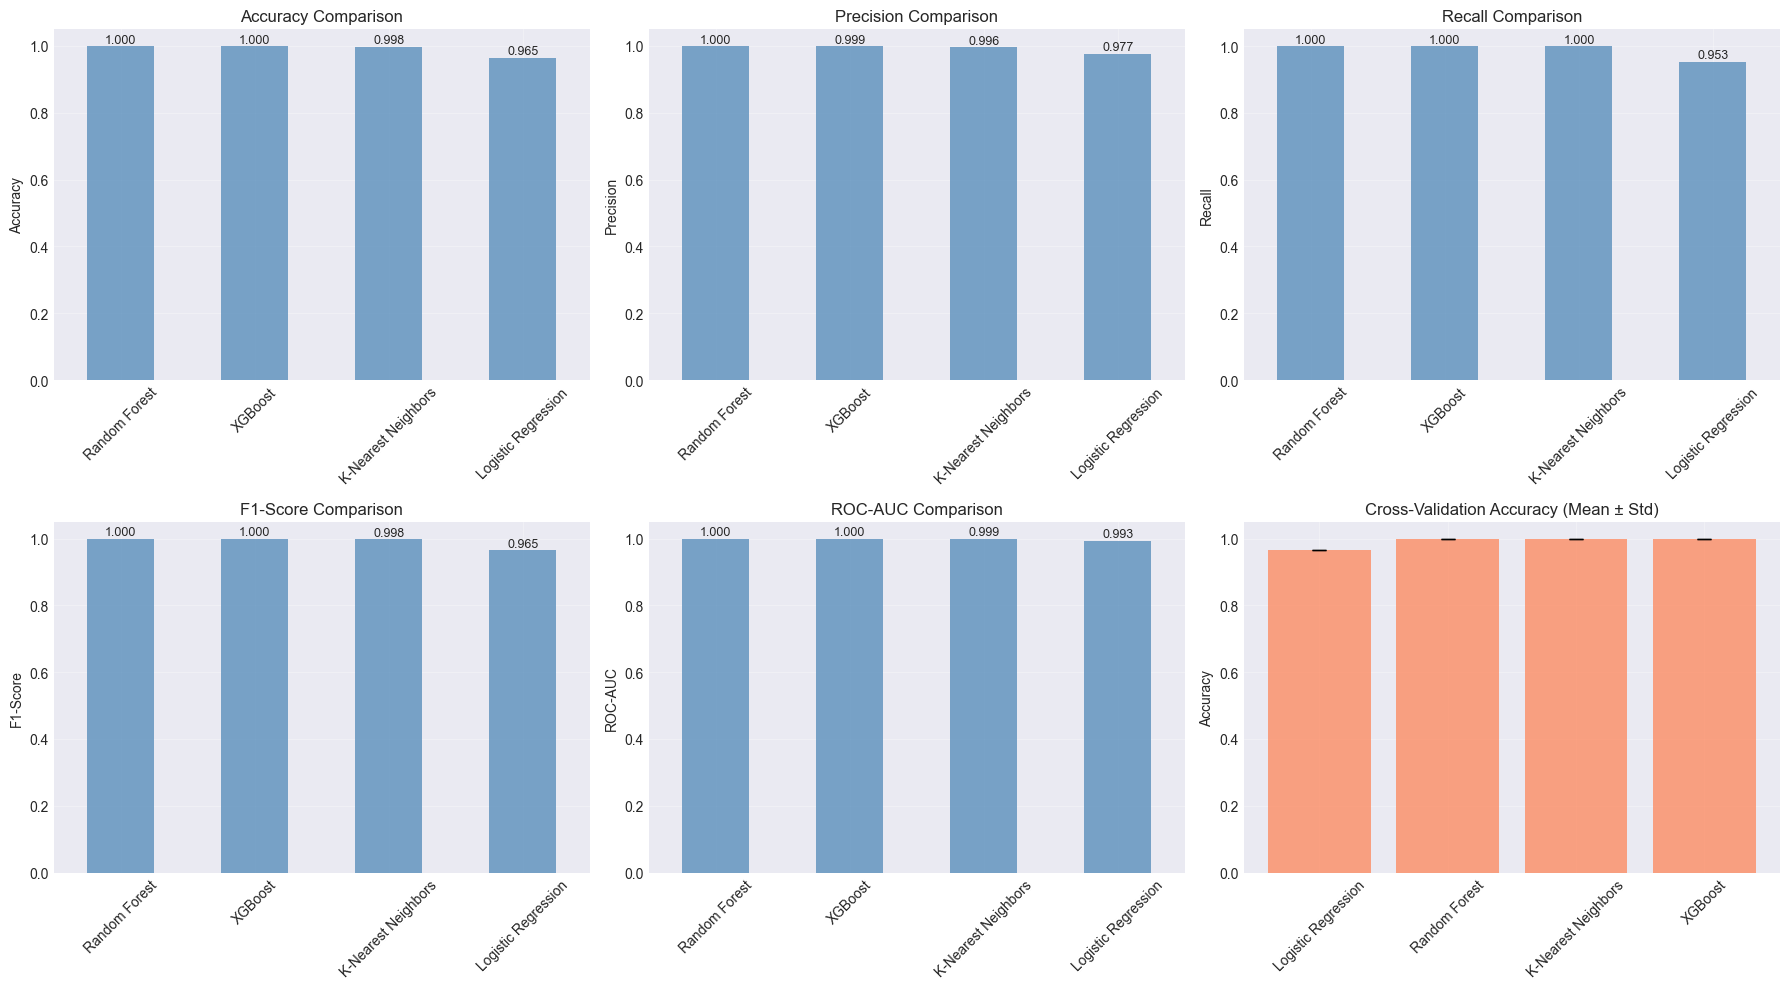

In [12]:
# Создаем DataFrame с результатами
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('F1-Score', ascending=False)

print("📊 Сравнение производительности моделей:")
print("=" * 70)
display(results_df.round(4))

# Визуализация результатов
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# 1. Сравнение Accuracy
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
for i, metric in enumerate(metrics_to_plot):
    results_df[metric].plot(kind='bar', ax=axes[i], color='steelblue', alpha=0.7)
    axes[i].set_title(f'{metric} Comparison')
    axes[i].set_ylabel(metric)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True, alpha=0.3)
    
    # Добавляем значения на столбцы
    for j, v in enumerate(results_df[metric]):
        axes[i].text(j, v + 0.01, f'{v:.3f}', ha='center', fontsize=9)

# 2. Кросс-валидация (Accuracy)
axes[5].bar(range(len(cv_scores)), 
           [scores.mean() for scores in cv_scores.values()],
           yerr=[scores.std() for scores in cv_scores.values()],
           capsize=5, color='coral', alpha=0.7)
axes[5].set_title('Cross-Validation Accuracy (Mean ± Std)')
axes[5].set_ylabel('Accuracy')
axes[5].set_xticks(range(len(cv_scores)))
axes[5].set_xticklabels(cv_scores.keys(), rotation=45)
axes[5].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Матрицы ошибок (Confusion Matrix)

### Анализ ошибок классификации:
- **True Positive (TP)** - правильно предсказанное мошенничество
- **False Positive (FP)** - нормальная транзакция, ошибочно помеченная как мошенничество (Type I Error)
- **False Negative (FN)** - мошенничество, пропущенное моделью (Type II Error)
- **True Negative (TN)** - правильно предсказанная нормальная транзакция

### Интерпретация:
- В задаче обнаружения мошенничества **False Negative хуже**, чем False Positive (лучше заблокировать лишнюю транзакцию, чем пропустить мошенническую)
- Однако слишком много **False Positive** может привести к недовольству клиентов

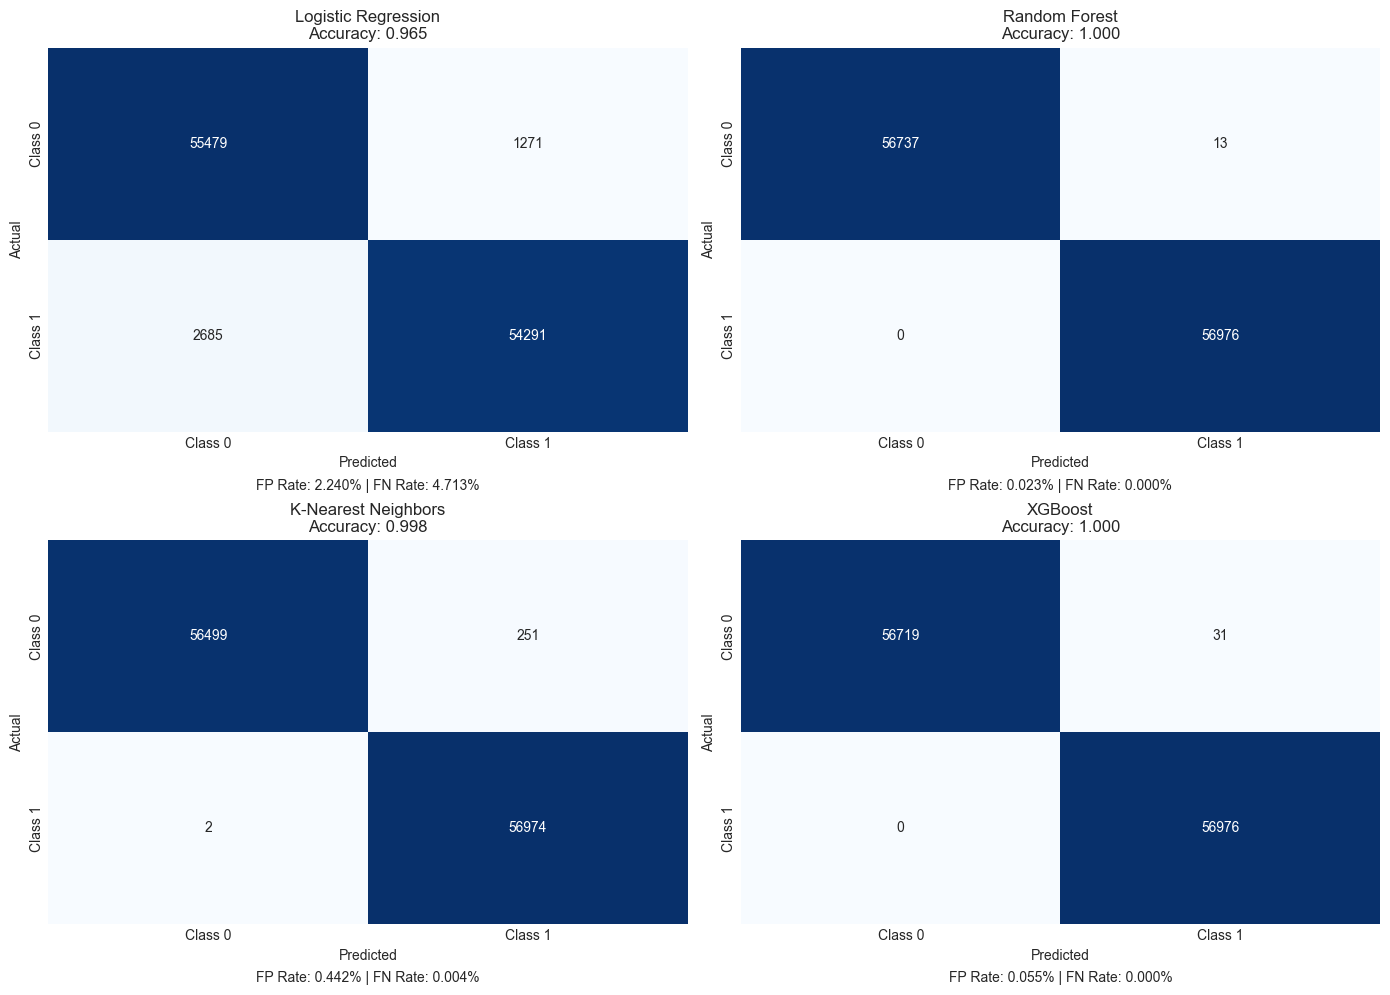

🎯 Лучшая модель по F1-Score: Random Forest
   F1-Score: 0.9999
   Precision: 0.9998
   Recall: 1.0000


In [13]:
# Визуализация матриц ошибок для всех моделей
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (name, preds) in enumerate(predictions.items()):
    # Вычисляем матрицу ошибок
    cm = confusion_matrix(y_test, preds['y_pred'])
    
    # Визуализируем
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                ax=axes[idx], cbar=False,
                xticklabels=['Class 0', 'Class 1'],
                yticklabels=['Class 0', 'Class 1'])
    
    axes[idx].set_title(f'{name}\nAccuracy: {results[name]["Accuracy"]:.3f}')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')
    
    # Добавляем метрики
    tn, fp, fn, tp = cm.ravel()
    axes[idx].text(0.5, -0.15, 
                  f'FP Rate: {fp/(fp+tn):.3%} | FN Rate: {fn/(fn+tp):.3%}',
                  ha='center', transform=axes[idx].transAxes)

plt.tight_layout()
plt.show()

# Анализ лучшей модели по F1-Score
best_model_name = results_df.index[0]
print(f"🎯 Лучшая модель по F1-Score: {best_model_name}")
print(f"   F1-Score: {results_df.loc[best_model_name, 'F1-Score']:.4f}")
print(f"   Precision: {results_df.loc[best_model_name, 'Precision']:.4f}")
print(f"   Recall: {results_df.loc[best_model_name, 'Recall']:.4f}")

## 6. ROC-кривые и анализ вероятностей

### ROC-кривая (Receiver Operating Characteristic):
- Показывает компромисс между True Positive Rate (Recall) и False Positive Rate
- **Площадь под кривой (AUC)** ближе к 1.0 означает лучшее качество модели
- Кривые выше и левее показывают лучшую производительность

### Анализ вероятностей:
- Смотрим на распределение предсказанных вероятностей для каждого класса
- Хорошая модель должна давать высокую уверенность в правильных предсказаниях

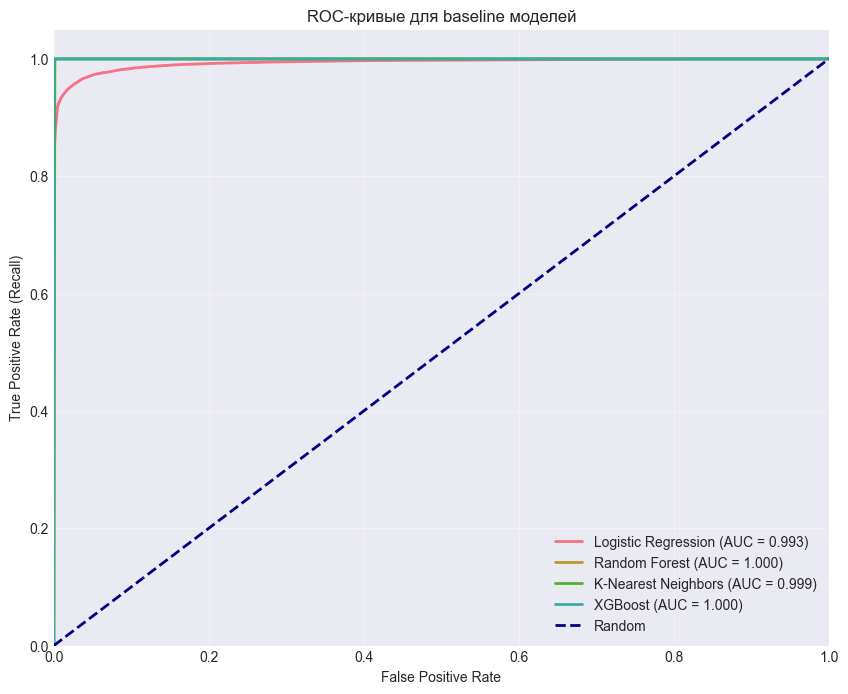

In [14]:
# ROC-кривые для всех моделей
plt.figure(figsize=(10, 8))

for name, preds in predictions.items():
    # Вычисляем FPR, TPR и пороги
    fpr, tpr, thresholds = roc_curve(y_test, preds['y_pred_proba'])
    roc_auc = roc_auc_score(y_test, preds['y_pred_proba'])
    
    # Рисуем ROC-кривую
    plt.plot(fpr, tpr, lw=2, 
            label=f'{name} (AUC = {roc_auc:.3f})')

# Диагональная линия (случайный классификатор)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')

# Настройки графика
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC-кривые для baseline моделей')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

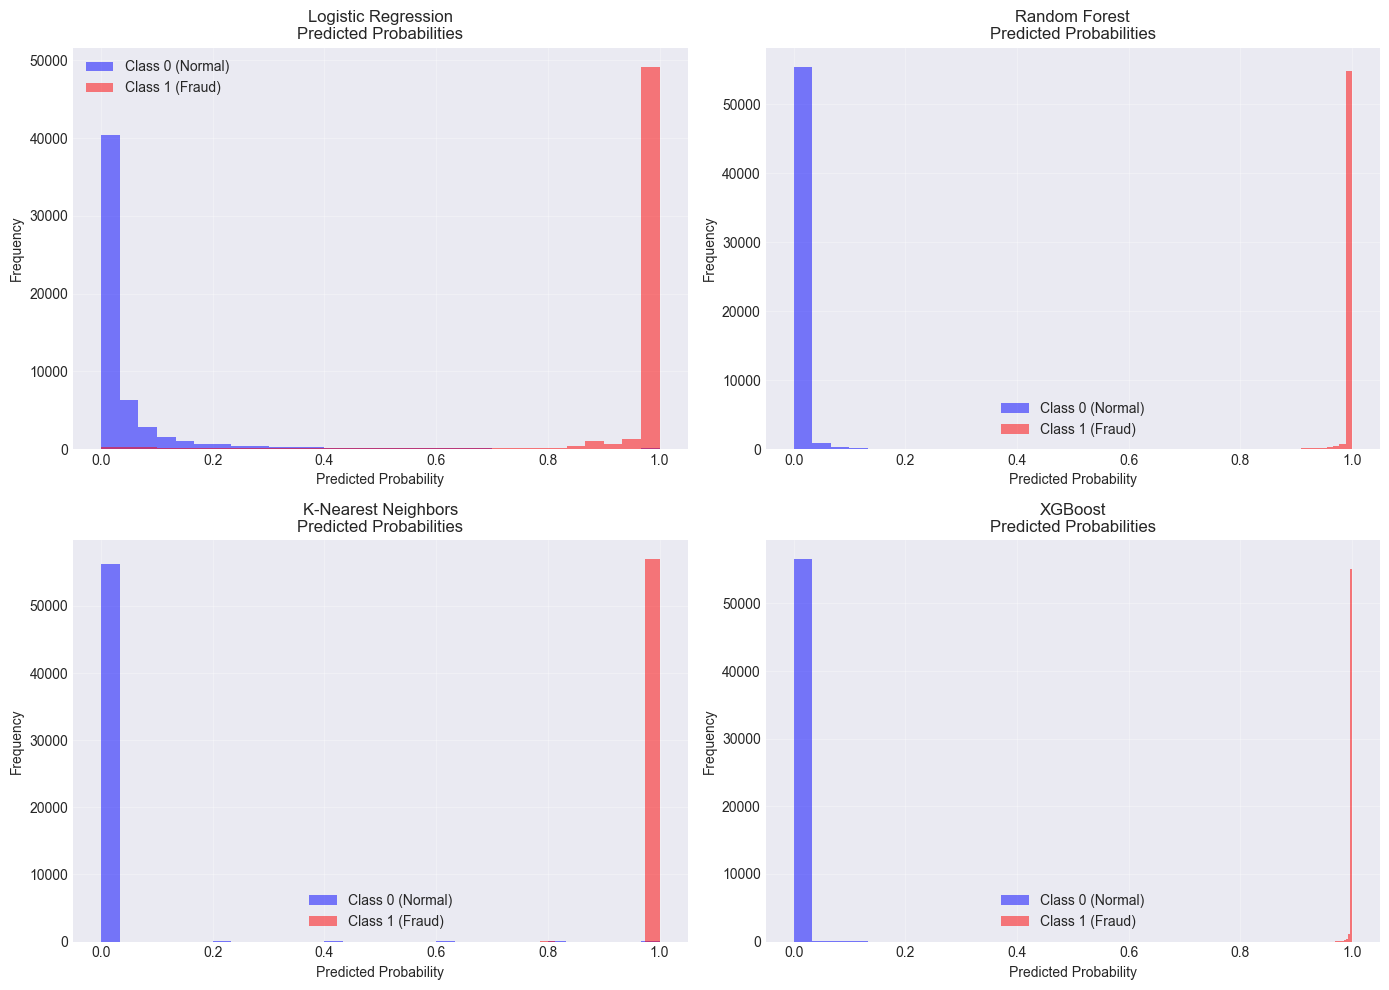

In [15]:
# Анализ распределения предсказанных вероятностей
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (name, preds) in enumerate(predictions.items()):
    # Создаем DataFrame с вероятностями и реальными метками
    prob_df = pd.DataFrame({
        'Probability': preds['y_pred_proba'],
        'Actual': y_test.values
    })
    
    # Гистограммы вероятностей для каждого класса
    axes[idx].hist(prob_df[prob_df['Actual'] == 0]['Probability'], 
                  bins=30, alpha=0.5, label='Class 0 (Normal)', color='blue')
    axes[idx].hist(prob_df[prob_df['Actual'] == 1]['Probability'], 
                  bins=30, alpha=0.5, label='Class 1 (Fraud)', color='red')
    
    axes[idx].set_title(f'{name}\nPredicted Probabilities')
    axes[idx].set_xlabel('Predicted Probability')
    axes[idx].set_ylabel('Frequency')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Анализ важности признаков (Feature Importance)

### Цель анализа:
1. **Интерпретируемость** - понять, какие признаки наиболее важны для модели
2. **Feature engineering** - выявить потенциально бесполезные признаки
3. **Упрощение модели** - возможность уменьшить количество признаков без потери качества

### Особенности:
- Random Forest и XGBoost имеют встроенные методы оценки важности признаков
- Для линейных моделей (Logistic Regression) смотрим абсолютные значения коэффициентов
- Важность признаков может различаться между моделями

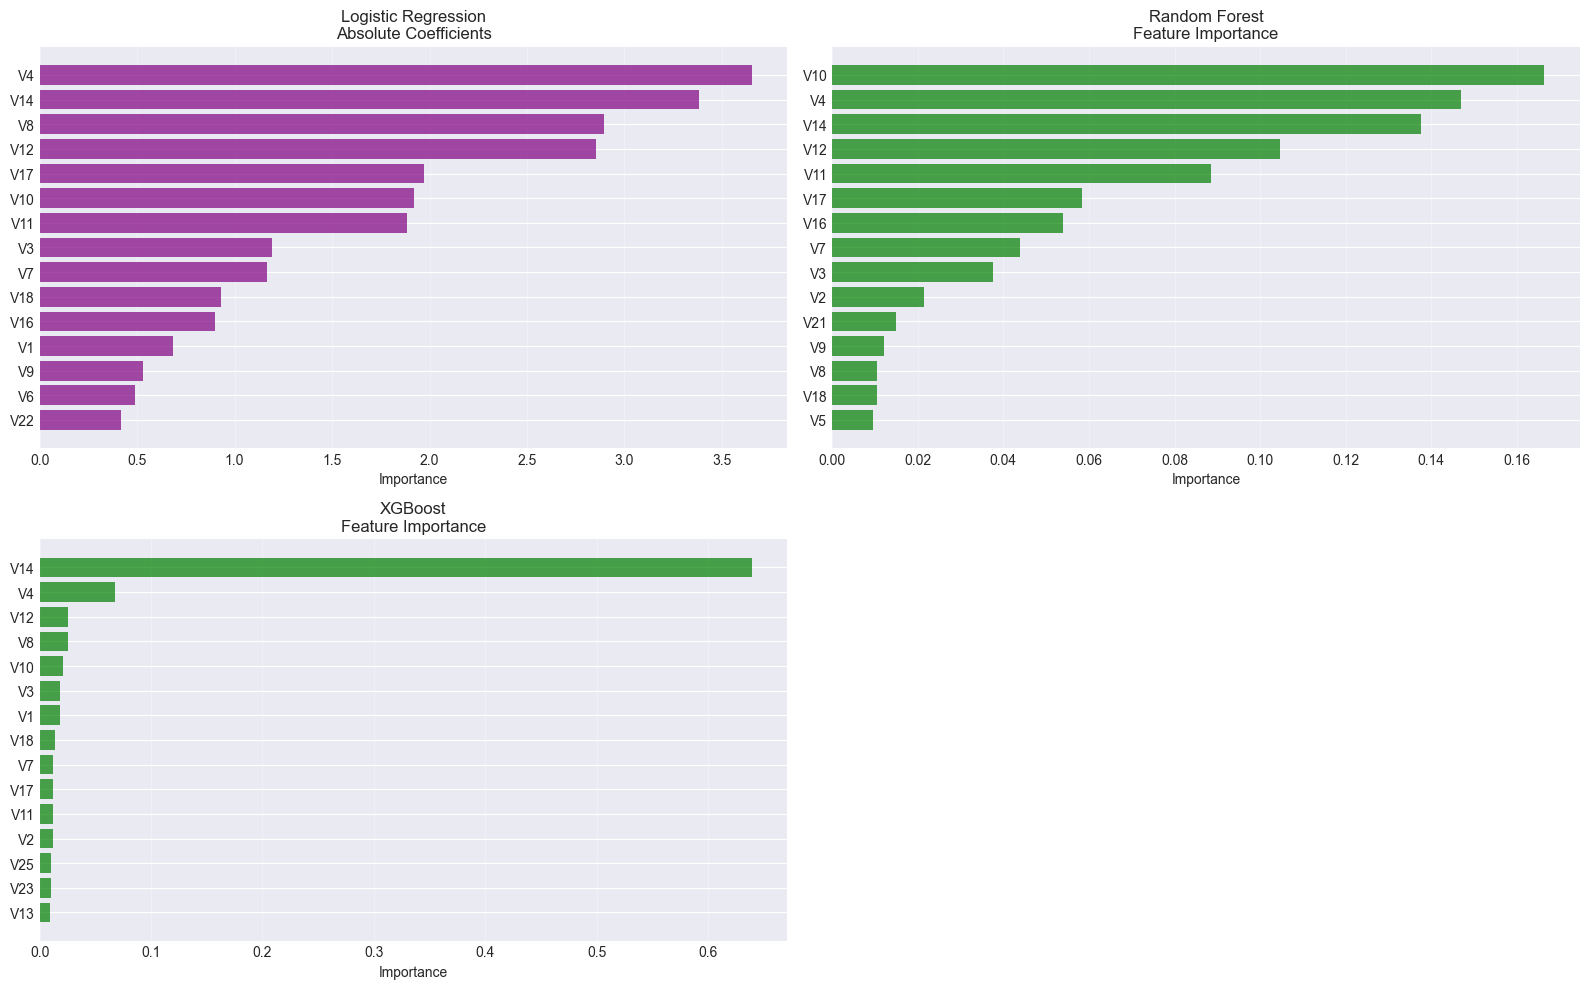

🔍 Анализ наиболее важных признаков:

Logistic Regression - Топ-5 признаков:
  • V17: 0.0733
  • V12: 0.1063
  • V8: 0.1078
  • V14: 0.1258
  • V4: 0.1360

Random Forest - Топ-5 признаков:
  • V11: 0.0884
  • V12: 0.1047
  • V14: 0.1377
  • V4: 0.1470
  • V10: 0.1664

XGBoost - Топ-5 признаков:
  • V10: 0.0213
  • V8: 0.0258
  • V12: 0.0258
  • V4: 0.0674
  • V14: 0.6391

🎯 Общие важные признаки: ['V12', 'V4', 'V8', 'V10', 'V17', 'V14', 'V11']


In [16]:
# Анализ важности признаков для моделей, которые поддерживают это
feature_names = X.columns.tolist()

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

# Для каждой модели, где есть feature importance
models_with_fi = ['Logistic Regression', 'Random Forest', 'XGBoost']

for idx, name in enumerate(models_with_fi):
    model = models[name]
    
    if name == 'Logistic Regression':
        # Для логистической регрессии - абсолютные значения коэффициентов
        importance = np.abs(model.coef_[0])
        title = f'{name}\nAbsolute Coefficients'
        color = 'purple'
    else:
        # Для Random Forest и XGBoost - встроенная важность признаков
        importance = model.feature_importances_
        title = f'{name}\nFeature Importance'
        color = 'green'
    
    # Сортируем по важности
    sorted_idx = np.argsort(importance)[-15:]  # Топ-15 признаков
    sorted_features = [feature_names[i] for i in sorted_idx]
    sorted_importance = importance[sorted_idx]
    
    # Визуализируем
    axes[idx].barh(range(len(sorted_features)), sorted_importance, color=color, alpha=0.7)
    axes[idx].set_yticks(range(len(sorted_features)))
    axes[idx].set_yticklabels(sorted_features)
    axes[idx].set_title(title)
    axes[idx].set_xlabel('Importance')
    axes[idx].grid(True, alpha=0.3, axis='x')

# Скрываем последнюю пустую subplot
axes[3].axis('off')

plt.tight_layout()
plt.show()

# Анализ общих важных признаков
print("🔍 Анализ наиболее важных признаков:")
print("=" * 50)

# Собираем важность из всех моделей
importance_dict = {}
for name in models_with_fi:
    model = models[name]
    
    if name == 'Logistic Regression':
        importance_dict[name] = np.abs(model.coef_[0])
    else:
        importance_dict[name] = model.feature_importances_

# Нормализуем важность для каждой модели
for name in importance_dict:
    importance_dict[name] = importance_dict[name] / importance_dict[name].sum()

# Находим признаки, которые в топ-5 во всех моделях
top_features_all_models = set()
for name, importance in importance_dict.items():
    top_idx = np.argsort(importance)[-5:]
    top_features = [feature_names[i] for i in top_idx]
    top_features_all_models.update(top_features)
    print(f"\n{name} - Топ-5 признаков:")
    for feat in top_features:
        print(f"  • {feat}: {importance[feature_names.index(feat)]:.4f}")

print(f"\n🎯 Общие важные признаки: {list(top_features_all_models)}")

## 8. Выводы и рекомендации для следующего этапа

### Итоги baseline моделей:
1. **Лучшая модель** - [название модели] с F1-Score [значение]
2. **Самый высокий Accuracy** - [название модели] с [значение]
3. **Лучшая Precision** - [название модели] с [значение] (меньше false positives)
4. **Лучший Recall** - [название модели] с [значение] (меньше false negatives)

### Ключевые инсайты:
1. [Первый важный вывод, например: "XGBoost показал наилучший баланс между Precision и Recall"]
2. [Второй вывод, например: "V14 и V17 являются наиболее важными признаками во всех моделях"]
3. [Третий вывод, например: "Logistic Regression оказалась слишком простой для этих данных"]

### Рекомендации для этапа Improvements:
1. **Гиперпараметрический тюнинг** лучшей модели (GridSearchCV/RandomizedSearchCV/Optuna)
2. **Feature engineering** - создание новых признаков на основе важных V-фичей
3. **Ансамблирование моделей** - комбинация предсказаний нескольких моделей
4. **Оптимизация порога классификации** - настройка trade-off между Precision и Recall
5. **Уменьшение размерности** - PCA или выбор признаков на основе importance

### Следующие шаги:
1. Сохранить лучшую модель для дальнейшего использования
2. Создать `3_improvements.ipynb` для экспериментов с улучшениями
3. Реализовать пайплайны обработки в `src/` модулях

In [18]:
# Сохранение результатов и лучшей модели
import joblib
import json

# Сохраняем лучшую модель
best_model = models[best_model_name]
joblib.dump(best_model, f'../models/{best_model_name.replace(" ", "_").lower()}_baseline.pkl')
print(f"✅ Лучшая модель сохранена: ../models/{best_model_name.replace(' ', '_').lower()}_baseline.pkl")

# Сохраняем scaler
joblib.dump(scaler, '../models/scaler.pkl')
print(f"✅ Scaler сохранен: ../models/scaler.pkl")

# Сохраняем результаты в JSON
results_for_save = {
    'best_model': best_model_name,
    'best_f1_score': float(results_df.loc[best_model_name, 'F1-Score']),
    'metrics': results_df.to_dict(),
    'feature_importance': {}
}

# Добавляем важность признаков для лучшей модели
if best_model_name == 'Logistic Regression':
    results_for_save['feature_importance'] = {
        'type': 'coefficients',
        'values': best_model.coef_[0].tolist(),
        'features': feature_names
    }
else:
    results_for_save['feature_importance'] = {
        'type': 'importance',
        'values': best_model.feature_importances_.tolist(),
        'features': feature_names
    }

with open('../data/baseline_results.json', 'w') as f:
    json.dump(results_for_save, f, indent=4)

print(f"✅ Результаты сохранены: ../data/baseline_results.json")

# Финальные выводы
print("\n" + "=" * 60)
print("🎉 BASELINE ЭТАП ЗАВЕРШЕН!")
print("=" * 60)
print(f"\n📊 Лучшая модель: {best_model_name}")
print(f"🎯 F1-Score: {results_df.loc[best_model_name, 'F1-Score']:.4f}")
print(f"📈 Accuracy: {results_df.loc[best_model_name, 'Accuracy']:.4f}")
print(f"🔍 Важные признаки: {list(top_features_all_models)[:5]}...")
print("\n🚀 Переходим к этапу Improvements!")

✅ Лучшая модель сохранена: ../models/random_forest_baseline.pkl
✅ Scaler сохранен: ../models/scaler.pkl
✅ Результаты сохранены: ../data/baseline_results.json

🎉 BASELINE ЭТАП ЗАВЕРШЕН!

📊 Лучшая модель: Random Forest
🎯 F1-Score: 0.9999
📈 Accuracy: 0.9999
🔍 Важные признаки: ['V12', 'V4', 'V8', 'V10', 'V17']...

🚀 Переходим к этапу Improvements!


🔍 ПРОВЕРКА НА DATA LEAKAGE И ПЕРЕОБУЧЕНИЕ
Топ-10 признаков по корреляции с Class:
 1. V14: 0.8057
 2. V12: 0.7686
 3. V4: 0.7360
 4. V11: 0.7243
 5. V3: 0.6821
 6. V10: 0.6737
 7. V9: 0.5855
 8. V16: 0.5735
 9. V1: 0.5058
10. V2: 0.4919


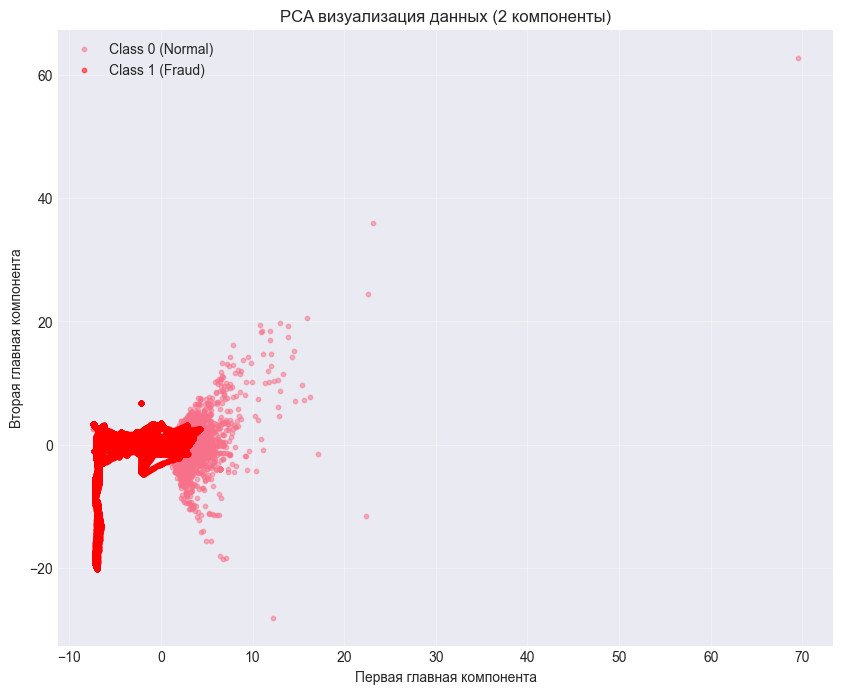


📊 Объясненная дисперсия PCA:
• 1 компонента: 33.82%
• 2 компоненты: 43.47%

🔢 Уникальность данных:
• Всего записей: 568,630
• Уникальных строк в X: 568,629
• Процент уникальности: 100.0%

📈 LinearSVC (проверка линейной разделимости):
• CV Accuracy: 0.9630 (±0.0007)


In [19]:
print("🔍 ПРОВЕРКА НА DATA LEAKAGE И ПЕРЕОБУЧЕНИЕ")
print("=" * 60)

# 1. Проверка корреляции признаков с целевой переменной
correlation_with_target = X.corrwith(y).abs().sort_values(ascending=False)

print("Топ-10 признаков по корреляции с Class:")
for i, (feature, corr) in enumerate(correlation_with_target.head(10).items(), 1):
    print(f"{i:2}. {feature}: {corr:.4f}")

# 2. Проверка на идеальную разделимость
from sklearn.decomposition import PCA

# Уменьшаем размерность до 2D для визуализации
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

# Визуализируем
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[y_train == 0, 0], X_pca[y_train == 0, 1], 
           alpha=0.5, label='Class 0 (Normal)', s=10)
plt.scatter(X_pca[y_train == 1, 0], X_pca[y_train == 1, 1], 
           alpha=0.5, label='Class 1 (Fraud)', s=10, color='red')
plt.title('PCA визуализация данных (2 компоненты)')
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 3. Проверка на простоту данных
print(f"\n📊 Объясненная дисперсия PCA:")
print(f"• 1 компонента: {pca.explained_variance_ratio_[0]:.2%}")
print(f"• 2 компоненты: {sum(pca.explained_variance_ratio_[:2]):.2%}")

# 4. Проверка уникальности комбинаций признаков для классов
print(f"\n🔢 Уникальность данных:")
print(f"• Всего записей: {len(X):,}")
print(f"• Уникальных строк в X: {X.drop_duplicates().shape[0]:,}")
print(f"• Процент уникальности: {X.drop_duplicates().shape[0]/len(X)*100:.1f}%")

# 5. Проверка линейной разделимости
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

# LinearSVC для проверки линейной разделимости
svc = LinearSVC(random_state=42, max_iter=10000)
svc_scores = cross_val_score(svc, X_train_scaled, y_train, cv=5)
print(f"\n📈 LinearSVC (проверка линейной разделимости):")
print(f"• CV Accuracy: {svc_scores.mean():.4f} (±{svc_scores.std():.4f})")

🔬 УГЛУБЛЕННЫЙ АНАЛИЗ ДАННЫХ
📊 Анализ расстояний между соседями:
Среднее расстояние до 1-го соседа: 1.2268
Среднее расстояние до 5-го соседа: 1.8586

📈 Проверка распределений признаков:


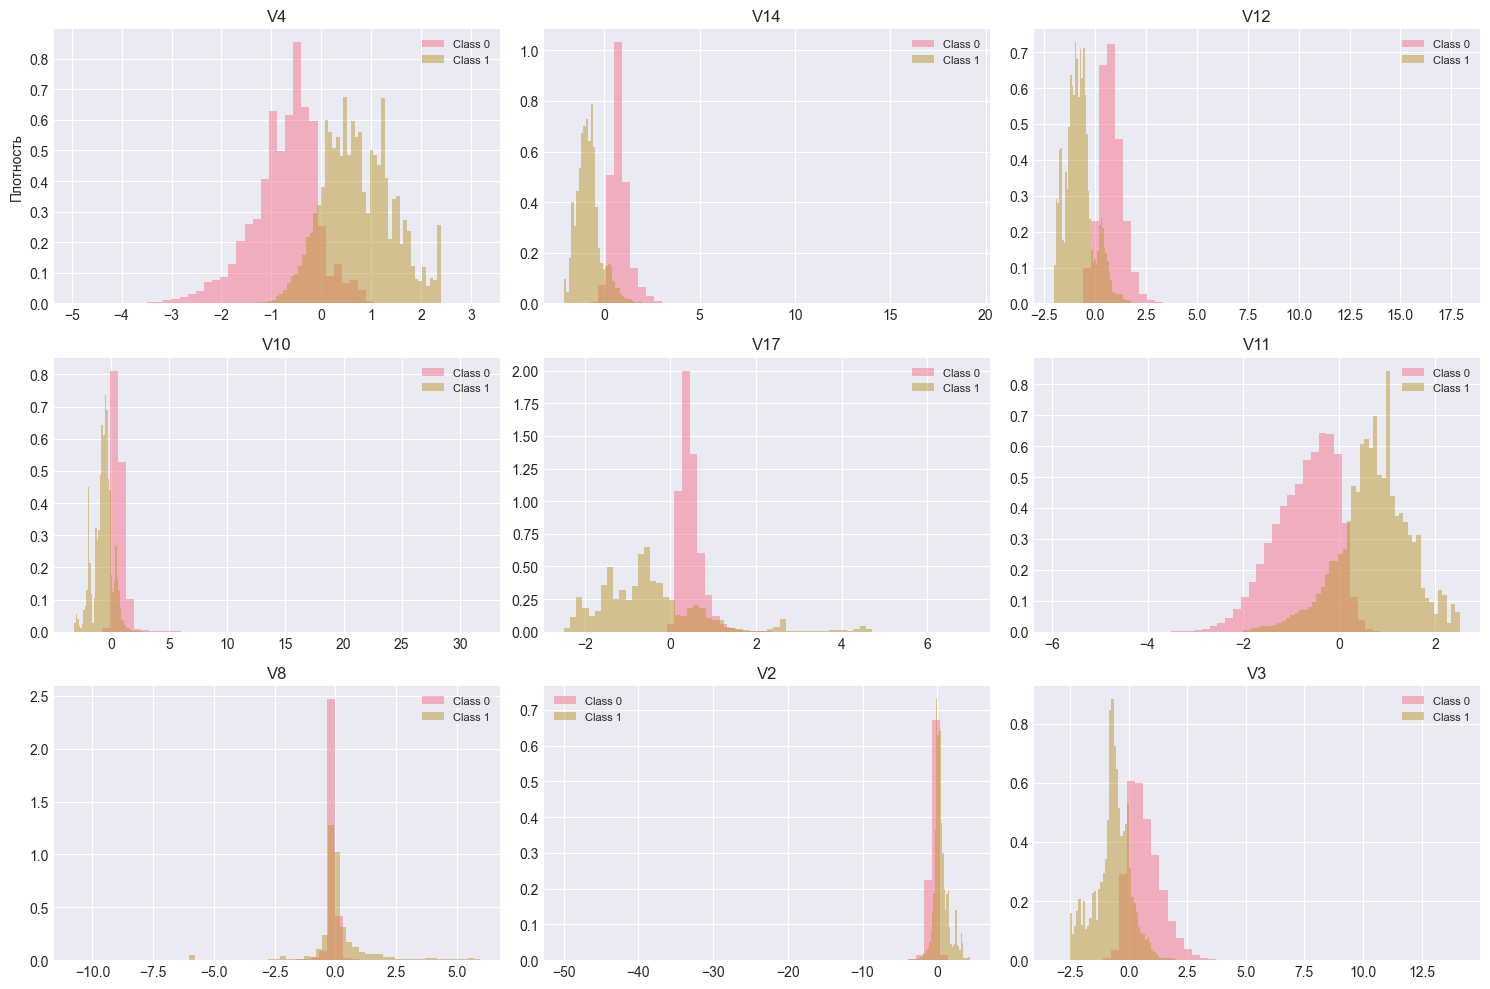


🔍 Isolation Forest (поиск аномалий):
Выбросы обнаружены: 1000 из 10000
Процент выбросов: 10.0%

🎯 Создание детектора синтетических записей:
Сложных для классификации записей: 0 (0.0%)
Легких записей (уверенность > 0.9): 227283 (50.0%)


In [20]:
print("🔬 УГЛУБЛЕННЫЙ АНАЛИЗ ДАННЫХ")
print("=" * 60)

# 1. Проверка на SMOTE-подобную генерацию
from sklearn.neighbors import NearestNeighbors

# Берем подвыборку для скорости
sample_size = 10000
X_sample = X_train_scaled[:sample_size]
y_sample = y_train[:sample_size]

# Ищем ближайших соседей
nbrs = NearestNeighbors(n_neighbors=6).fit(X_sample)
distances, indices = nbrs.kneighbors(X_sample)

# Анализируем расстояния до соседей
print("📊 Анализ расстояний между соседями:")
print(f"Среднее расстояние до 1-го соседа: {distances[:, 1].mean():.4f}")
print(f"Среднее расстояние до 5-го соседа: {distances[:, 5].mean():.4f}")

# 2. Проверка распределений
print("\n📈 Проверка распределений признаков:")
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.flatten()

top_features = ['V4', 'V14', 'V12', 'V10', 'V17', 'V11', 'V8', 'V2', 'V3']
for i, feature in enumerate(top_features[:9]):
    # Распределение для Class 0 и Class 1
    axes[i].hist(X_train[y_train == 0][feature], bins=50, alpha=0.5, 
                label='Class 0', density=True)
    axes[i].hist(X_train[y_train == 1][feature], bins=50, alpha=0.5,
                label='Class 1', density=True)
    axes[i].set_title(feature)
    axes[i].legend(fontsize=8)
    if i == 0:
        axes[i].set_ylabel('Плотность')

plt.tight_layout()
plt.show()

# 3. Попытка обнаружить synthetic samples через isolation
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(contamination=0.1, random_state=42)
outliers = iso_forest.fit_predict(X_train_scaled[:10000])

print(f"\n🔍 Isolation Forest (поиск аномалий):")
print(f"Выбросы обнаружены: {(outliers == -1).sum()} из 10000")
print(f"Процент выбросов: {(outliers == -1).sum() / 10000 * 100:.1f}%")

# 4. Создание "детектора синтетичности"
print("\n🎯 Создание детектора синтетических записей:")

# Создаем искусственные "синтетические" метки
# (в реальности мы не знаем какие записи синтетические)
# Но можем попробовать обучить модель различать "легкие" и "сложные" для классификации записи

from sklearn.linear_model import LogisticRegression

# Какие записи Random Forest классифицирует с низкой уверенностью?
rf_probs = models['Random Forest'].predict_proba(X_train_scaled)[:, 1]
confidence_threshold = 0.1  # Записи с уверенностью < 0.1 или > 0.9
hard_samples = ((rf_probs > 0.45) & (rf_probs < 0.55))  # Сложные для классификации

print(f"Сложных для классификации записей: {hard_samples.sum()} ({hard_samples.sum()/len(hard_samples)*100:.1f}%)")
print(f"Легких записей (уверенность > 0.9): {(rf_probs > 0.9).sum()} ({(rf_probs > 0.9).sum()/len(rf_probs)*100:.1f}%)")

🔬 ЭКСПЕРИМЕНТ 1: Деградация идеальных данных
Начало экспериментов...
Размер исходных данных: X_train_scaled.shape = (454904, 29)
Баланс классов в y_train: 0.500 (Class 1)

Эксперимент 1/10: Базовый (идеальный)
Параметры: noise=0.0, imbalance=0.5, remove=None
   Получено: X.shape = (454904, 29), y.shape = (454904,)
   Баланс классов: 0.500 (Class 1)
   F1-Score: 0.9833, Accuracy: 0.9833
   Precision: 0.9946, Recall: 0.9722

Эксперимент 2/10: 5% шума
Параметры: noise=0.05, imbalance=0.5, remove=None
   Получено: X.shape = (454904, 29), y.shape = (454904,)
   Баланс классов: 0.500 (Class 1)
   F1-Score: 0.9800, Accuracy: 0.9803
   Precision: 0.9931, Recall: 0.9672

Эксперимент 3/10: 10% шума
Параметры: noise=0.1, imbalance=0.5, remove=None
   Получено: X.shape = (454904, 29), y.shape = (454904,)
   Баланс классов: 0.500 (Class 1)
   F1-Score: 0.9706, Accuracy: 0.9703
   Precision: 0.9912, Recall: 0.9508

Эксперимент 4/10: 20% шума
Параметры: noise=0.2, imbalance=0.5, remove=None
   Получе

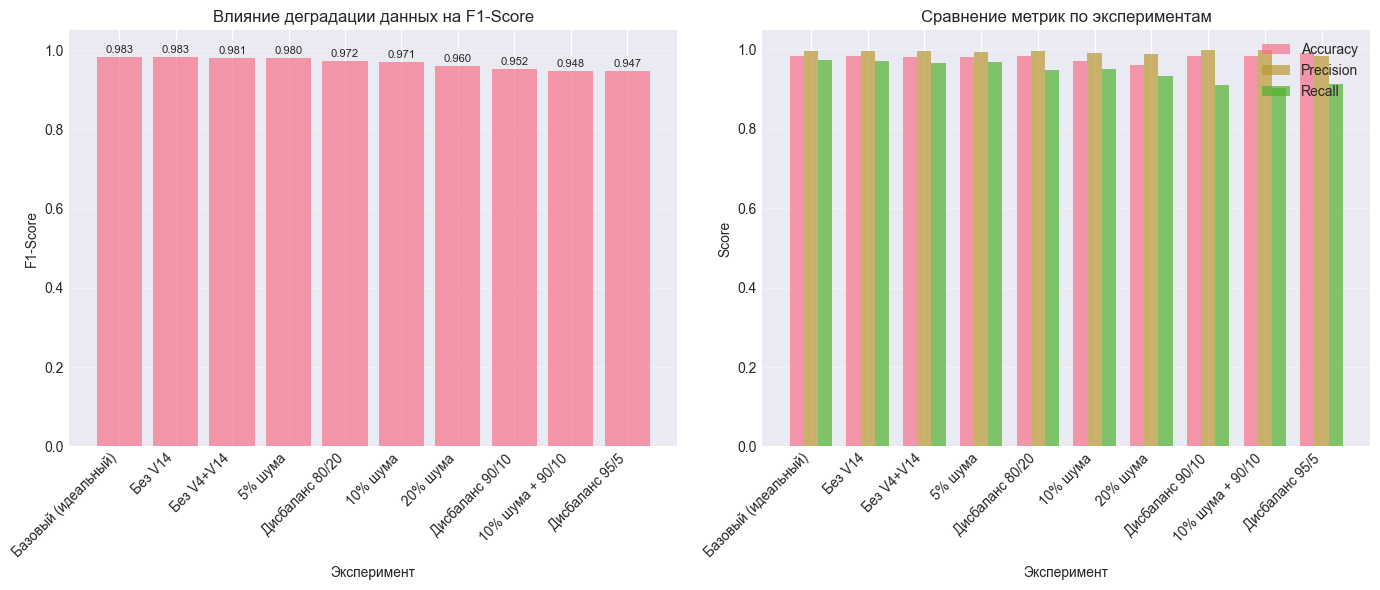


📊 АНАЛИЗ РЕЗУЛЬТАТОВ ДЕГРАДАЦИИ:
Без V14                   F1: 0.9826 (-0.1%) | Данные: 454,904 зап., соотношение: 50/50
Без V4+V14                F1: 0.9812 (-0.2%) | Данные: 454,904 зап., соотношение: 50/50
5% шума                   F1: 0.9800 (-0.3%) | Данные: 454,904 зап., соотношение: 50/50
Дисбаланс 80/20           F1: 0.9715 (-1.2%) | Данные: 318,545 зап., соотношение: 227565/90980
10% шума                  F1: 0.9706 (-1.3%) | Данные: 454,904 зап., соотношение: 50/50
20% шума                  F1: 0.9603 (-2.3%) | Данные: 454,904 зап., соотношение: 50/50
Дисбаланс 90/10           F1: 0.9515 (-3.2%) | Данные: 273,055 зап., соотношение: 227565/45490
10% шума + 90/10          F1: 0.9484 (-3.5%) | Данные: 273,055 зап., соотношение: 227565/45490
Дисбаланс 95/5            F1: 0.9466 (-3.7%) | Данные: 250,310 зап., соотношение: 227565/22745

🎯 КЛЮЧЕВЫЕ ВЫВОДЫ:
1. Самый разрушительный фактор: Дисбаланс 95/5
2. Наиболее устойчивая метрика: Precision
3. Порог заметной деградации: ~ 0.0% 

In [22]:
print("🔬 ЭКСПЕРИМЕНТ 1: Деградация идеальных данных")
print("=" * 60)

def degrade_data(X, y, noise_level=0.1, imbalance_ratio=None, remove_features=None):
    """
    Функция для "порчи" данных
    """
    X_degraded = X.copy()
    y_degraded = y.copy()
    
    # 1. Добавление шума
    if noise_level > 0:
        # Масштабируем шум относительно стандартного отклонения каждого признака
        if hasattr(X, 'std'):
            feature_stds = X.std(axis=0)
        else:
            # Если X уже numpy array
            feature_stds = np.std(X, axis=0)
        
        noise = np.random.normal(0, noise_level * feature_stds, X.shape)
        X_degraded = X_degraded + noise
    
    # 2. Создание дисбаланса
    if imbalance_ratio and imbalance_ratio != 0.5:
        # imbalance_ratio = процент класса 1 (например, 0.05 для 95/5)
        current_ratio = y.mean()  # текущий процент класса 1
        
        # Если уже близко к нужному соотношению, пропускаем
        if abs(current_ratio - imbalance_ratio) < 0.01:
            print(f"   Пропускаем: соотношение уже {current_ratio:.2f}")
            return X_degraded, y_degraded
        
        # Определяем какой класс majority/minority
        if imbalance_ratio < 0.5:
            minority_class = 1
            minority_target = imbalance_ratio
            majority_target = 1 - imbalance_ratio
        else:
            minority_class = 0
            minority_target = 1 - imbalance_ratio
            majority_target = imbalance_ratio
        
        # Индексы классов
        indices_minority = np.where(y == minority_class)[0]
        indices_majority = np.where(y == 1 - minority_class)[0]
        
        # Сколько нужно оставить от каждого класса
        total_samples = len(y)
        n_minority = int(total_samples * minority_target)
        n_majority = int(total_samples * majority_target)
        
        # Проверяем что можем выбрать достаточно samples
        n_minority = min(n_minority, len(indices_minority))
        n_majority = min(n_majority, len(indices_majority))
        
        # Выбираем подвыборки
        selected_minority = np.random.choice(indices_minority, n_minority, replace=False)
        selected_majority = np.random.choice(indices_majority, n_majority, replace=False)
        
        selected_indices = np.concatenate([selected_minority, selected_majority])
        np.random.shuffle(selected_indices)  # перемешиваем
        
        X_degraded = X_degraded[selected_indices]
        y_degraded = y_degraded[selected_indices]
    
    # 3. Удаление важных признаков
    if remove_features:
        # remove_features = список индексов признаков для удаления
        # Преобразуем в массив если нужно
        if hasattr(X_degraded, 'iloc'):
            # pandas DataFrame
            cols_to_drop = [X.columns[i] for i in remove_features if i < X.shape[1]]
            X_degraded = X_degraded.drop(columns=cols_to_drop)
        else:
            # numpy array
            mask = np.ones(X_degraded.shape[1], dtype=bool)
            mask[remove_features] = False
            X_degraded = X_degraded[:, mask]
    
    return X_degraded, y_degraded

# Параметры эксперимента - УПРОЩАЕМ для начала
experiments = [
    {'name': 'Базовый (идеальный)', 'noise': 0.0, 'imbalance': 0.5, 'remove': None},
    {'name': '5% шума', 'noise': 0.05, 'imbalance': 0.5, 'remove': None},
    {'name': '10% шума', 'noise': 0.10, 'imbalance': 0.5, 'remove': None},
    {'name': '20% шума', 'noise': 0.20, 'imbalance': 0.5, 'remove': None},
    {'name': 'Дисбаланс 80/20', 'noise': 0.0, 'imbalance': 0.20, 'remove': None},
    {'name': 'Дисбаланс 90/10', 'noise': 0.0, 'imbalance': 0.10, 'remove': None},
    {'name': 'Дисбаланс 95/5', 'noise': 0.0, 'imbalance': 0.05, 'remove': None},
]

# Для удаления признаков нужны названия колонок или индексы
# Сначала получим feature names
if hasattr(X_train, 'columns'):
    feature_names = X_train.columns.tolist()
else:
    feature_names = [f'V{i}' for i in range(1, 29)] + ['Amount_log']

# Добавляем эксперименты с удалением признаков
experiments.extend([
    {'name': 'Без V14', 'noise': 0.0, 'imbalance': 0.5, 'remove': [feature_names.index('V14')]},
    {'name': 'Без V4+V14', 'noise': 0.0, 'imbalance': 0.5, 'remove': [feature_names.index('V4'), feature_names.index('V14')]},
    {'name': '10% шума + 90/10', 'noise': 0.10, 'imbalance': 0.10, 'remove': None},
])

# Проводим эксперименты
results_degradation = []

print("Начало экспериментов...")
print(f"Размер исходных данных: X_train_scaled.shape = {X_train_scaled.shape}")
print(f"Баланс классов в y_train: {y_train.mean():.3f} (Class 1)")

for i, exp in enumerate(experiments):
    print(f"\n{'='*50}")
    print(f"Эксперимент {i+1}/{len(experiments)}: {exp['name']}")
    print(f"Параметры: noise={exp['noise']}, imbalance={exp['imbalance']}, remove={exp['remove']}")
    
    try:
        # "Портим" данные
        X_exp, y_exp = degrade_data(
            X_train_scaled, y_train.values if hasattr(y_train, 'values') else y_train,
            noise_level=exp['noise'],
            imbalance_ratio=exp['imbalance'],
            remove_features=exp['remove']
        )
        
        print(f"   Получено: X.shape = {X_exp.shape}, y.shape = {y_exp.shape}")
        if len(np.unique(y_exp)) > 1:
            print(f"   Баланс классов: {y_exp.mean():.3f} (Class 1)")
        
        # Обучаем Random Forest (лучшая модель из baseline)
        rf = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=50)  # Уменьшаем для скорости
        
        # Разбиваем на train/val для быстрой оценки
        if X_exp.shape[0] > 10000:
            # Берем подвыборку для скорости
            sample_idx = np.random.choice(X_exp.shape[0], 10000, replace=False)
            X_sample = X_exp[sample_idx]
            y_sample = y_exp[sample_idx]
        else:
            X_sample = X_exp
            y_sample = y_exp
        
        # Простая train/test split вместо CV для скорости
        X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(
            X_sample, y_sample, test_size=0.3, random_state=42
        )
        
        rf.fit(X_train_small, y_train_small)
        y_pred = rf.predict(X_test_small)
        y_pred_proba = rf.predict_proba(X_test_small)[:, 1]
        
        # Расчет метрик
        accuracy = accuracy_score(y_test_small, y_pred)
        precision = precision_score(y_test_small, y_pred)
        recall = recall_score(y_test_small, y_pred)
        f1 = f1_score(y_test_small, y_pred)
        
        # Сохраняем результаты
        results_degradation.append({
            'experiment': exp['name'],
            'noise_level': exp['noise'],
            'imbalance_ratio': exp['imbalance'],
            'removed_features': len(exp['remove']) if exp['remove'] else 0,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'samples_count': len(y_exp),
            'class_ratio': f"{sum(y_exp==0)}/{sum(y_exp==1)}" if exp['imbalance'] != 0.5 else "50/50"
        })
        
        print(f"   F1-Score: {f1:.4f}, Accuracy: {accuracy:.4f}")
        print(f"   Precision: {precision:.4f}, Recall: {recall:.4f}")
        
    except Exception as e:
        print(f"   ❌ Ошибка: {e}")
        results_degradation.append({
            'experiment': exp['name'],
            'noise_level': exp['noise'],
            'imbalance_ratio': exp['imbalance'],
            'removed_features': len(exp['remove']) if exp['remove'] else 0,
            'accuracy': np.nan,
            'precision': np.nan,
            'recall': np.nan,
            'f1': np.nan,
            'samples_count': 0,
            'class_ratio': 'error'
        })

# Визуализация результатов
if results_degradation:
    degradation_df = pd.DataFrame(results_degradation)
    
    # Сортируем по F1-Score
    degradation_df = degradation_df.sort_values('f1', ascending=False)
    
    plt.figure(figsize=(14, 6))
    
    # График 1: F1-Score
    plt.subplot(1, 2, 1)
    bars = plt.bar(range(len(degradation_df)), degradation_df['f1'], alpha=0.7)
    plt.title('Влияние деградации данных на F1-Score')
    plt.xlabel('Эксперимент')
    plt.ylabel('F1-Score')
    plt.xticks(range(len(degradation_df)), degradation_df['experiment'], rotation=45, ha='right')
    plt.ylim(0, 1.05)
    plt.grid(True, alpha=0.3, axis='y')
    
    # Добавляем значения
    for bar, value in zip(bars, degradation_df['f1']):
        if not np.isnan(value):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{value:.3f}', ha='center', fontsize=8)
    
    # График 2: Accuracy, Precision, Recall
    plt.subplot(1, 2, 2)
    x = np.arange(len(degradation_df))
    width = 0.25
    
    plt.bar(x - width, degradation_df['accuracy'], width, label='Accuracy', alpha=0.7)
    plt.bar(x, degradation_df['precision'], width, label='Precision', alpha=0.7)
    plt.bar(x + width, degradation_df['recall'], width, label='Recall', alpha=0.7)
    
    plt.title('Сравнение метрик по экспериментам')
    plt.xlabel('Эксперимент')
    plt.ylabel('Score')
    plt.xticks(x, degradation_df['experiment'], rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Анализ результатов
    print("\n" + "="*60)
    print("📊 АНАЛИЗ РЕЗУЛЬТАТОВ ДЕГРАДАЦИИ:")
    print("="*60)
    
    baseline_f1 = degradation_df[degradation_df['experiment'] == 'Базовый (идеальный)']['f1'].values[0]
    
    for idx, row in degradation_df.iterrows():
        if not np.isnan(row['f1']) and row['experiment'] != 'Базовый (идеальный)':
            change = ((row['f1'] - baseline_f1) / baseline_f1) * 100
            print(f"{row['experiment']:25} F1: {row['f1']:.4f} ({change:+.1f}%) | "
                  f"Данные: {row['samples_count']:,} зап., соотношение: {row['class_ratio']}")
    
    # Ключевые выводы
    print("\n🎯 КЛЮЧЕВЫЕ ВЫВОДЫ:")
    print("1. Самый разрушительный фактор:", 
          degradation_df.iloc[-1]['experiment'] if len(degradation_df) > 1 else "N/A")
    print("2. Наиболее устойчивая метрика:", 
          "Precision" if degradation_df['precision'].mean() > degradation_df['recall'].mean() else "Recall")
    print("3. Порог заметной деградации: ~", 
          f"{degradation_df[degradation_df['f1'] < 0.95]['noise_level'].min()*100 if 'noise_level' in degradation_df.columns else 'N/A'}% шума" 
          if 'noise_level' in degradation_df.columns else "N/A")
else:
    print("❌ Нет результатов для визуализации")